In [1]:
# import mysql.connector
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql as MySQLdb

In [2]:
pd.options.display.float_format = '{:,.8f}'.format


cnx = MySQLdb.connect(user='admin', password='rdx-mysql',
                              host='database-1.ccbb7nilplok.us-east-1.rds.amazonaws.com',
                              database='etl')

In [3]:
def SQL_TO_DF (SQL, cnx):
    
    cursor = cnx.cursor() 
    cursor.execute(SQL)

    values = list(cursor.fetchall())
    header = cursor.description
    cursor.close()
    columns = [i[0] for i in header]
    raw = pd.DataFrame(values, columns = columns)
    return raw

In [4]:
query1 = ("select * from event_incident_mapping where METRIC_NAME IN ('PctFree','dskPercent','used','utilization','PctTotal','LDldFreeSpacePct','UsedMBPct','LDldDiskTimePercent')")
raw = SQL_TO_DF(query1, cnx)

In [5]:
raw['POLLER_TIME_PERIOD_60_MIN'] = (raw['POLLER_TIME']/3600).astype(int)

In [6]:
raw

,DESTINATION,CORE_TIMESTAMP,POLLER_TIME,POLLER_TIMESTAMP,TARGET_ID,POLICY_ID,DETECTED_SEVERITY,PROPAGATED_SEVERITY,LOW_THRESHOLD,MEASURED_VALUE,...,PARENT_TARGET_ID,MONITOR_DESC,CORE_TIME_NUM,INCIDENT_ID,SUBMIT_DATE,SUBMIT_DATE_NUM,INC_EVENT_TIME_DIFF,MIN_DIFF,HAS_MAPPED_INCIDENT,POLLER_TIME_PERIOD_60_MIN
0,1,2019-09-07 02:27:39,1567823257,2019-09-07 02:27:37,1431915,1164,4,3,85,100.00,...,1431565,BMC: Disk,1567823259,None,NaT,nan,nan,nan,0,435506
1,1,2019-09-07 02:37:39,1567823857,2019-09-07 02:37:37,1431915,1164,4,3,85,100.00,...,1431565,BMC: Disk,1567823859,None,NaT,nan,nan,nan,0,435506
2,1,2019-09-05 04:02:39,1567656157,2019-09-05 04:02:37,1431918,1164,4,3,85,100.00,...,1431565,BMC: Disk,1567656159,None,NaT,nan,nan,nan,0,435460
3,1,2019-09-08 04:02:39,1567915357,2019-09-08 04:02:37,1431918,1164,4,3,85,100.00,...,1431565,BMC: Disk,1567915359,None,NaT,nan,nan,nan,0,435532
4,1,2019-09-03 04:02:39,1567483357,2019-09-03 04:02:37,1431918,1164,4,3,85,100.00,...,1431565,BMC: Disk,1567483359,None,NaT,nan,nan,nan,0,435412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198553,1,2019-09-07 21:52:07,1567893126,2019-09-07 21:52:06,2399248,4502,4,4,85,85.75,...,None,Server,1567893127,INC001000587646,2019-09-08 01:16:11,"1,567,905,371.00000000","12,244.00000000",nan,0,435525
1198554,1,2019-09-05 08:24:15,1567671855,2019-09-05 08:24:15,2491639,5003,5,5,95,100.44,...,None,WMI: Server,1567671855,INC001000585964,2019-09-05 11:50:30,"1,567,684,230.00000000","12,375.00000000",nan,0,435464
1198555,1,2019-09-07 22:40:30,1567896030,2019-09-07 22:40:30,2047418,2904,5,3,95,100.00,...,None,Server,1567896030,INC001000587669,2019-09-08 02:17:13,"1,567,909,033.00000000","13,003.00000000",nan,0,435526
1198556,1,2019-09-07 00:13:41,1567815221,2019-09-07 00:13:41,1086679,2222,4,4,5,11.99,...,1085277,WMI: Logical Disk,1567815221,INC001000587362,2019-09-07 04:00:34,"1,567,828,834.00000000","13,613.00000000",nan,0,435504


In [8]:
query2 = ("select * from incidents")
incidents = SQL_TO_DF(query2, cnx)

In [14]:
incidents['POLLER_TIME_PERIOD_60_MIN'] = (incidents['SUBMIT_DATE_NUM']/3600).astype(int)
incidents['WEEKDAY'] = incidents['SUBMIT_DATE'].dt.weekday
incidents['HOUR'] = incidents['SUBMIT_DATE'].dt.hour
incidents = incidents[['INCIDENT_ID','POLLER_TIME_PERIOD_60_MIN','EVENT_CODE_INC','RECON_ID_INC','WEEKDAY', 'HOUR']]
incidents

,INCIDENT_ID,POLLER_TIME_PERIOD_60_MIN,EVENT_CODE_INC,RECON_ID_INC,WEEKDAY,HOUR
0,INC001000583009,435360,WINT-06,OI-046012BC9CF011E89C74005056AC8828,6,0
1,INC001000583009,435360,WINT-06,OI-86ED1EAE9D1411E8A2D7005056AC8828,6,0
2,INC001000583010,435360,ZERTO-45,OI-860B42EA9D1411E8A292005056AC8828,6,0
3,INC001000583010,435360,ZERTO-45,OI-002791849CF011E898EC005056AC8828,6,0
4,INC001000583011,435360,ORCL-05,OI-0820E7329CF011E89FEB005056AC8828,6,0
...,...,...,...,...,...,...
7955,INC001000588838,435575,WINT-06,OI-713C32DE9D1411E89C4B005056AC8828,0,23
7956,INC001000588839,435575,SNMP-08,OI-E7A781FA9CEF11E8B341005056AC8828,0,23
7957,INC001000588839,435575,SNMP-08,OI-60DF0BDC9D1411E8978E005056AC8828,0,23
7958,INC001000588840,435575,ZERTO-05,OI-002791849CF011E898EC005056AC8828,0,23


In [65]:
merge60 = raw.merge(incidents, left_on=['RECON_ID','POLLER_TIME_PERIOD_60_MIN','EVENT_CODE'], right_on=['RECON_ID_INC','POLLER_TIME_PERIOD_60_MIN','EVENT_CODE_INC'], how='left')
# merge60 = raw.merge(incidents, left_on=['RECON_ID','POLLER_TIME_PERIOD_60_MIN'], right_on=['RECON_ID_INC','POLLER_TIME_PERIOD_60_MIN'], how='left')

In [66]:
len(merge60['INCIDENT_ID_y'].unique())
# merge60

269

In [67]:
merge60_partial = merge60[['POLLER_TIME','POLLER_TIME_PERIOD_60_MIN','METRIC_NAME','MEASURED_VALUE','RECON_ID','NEW_BUS_ID','SITE','INCIDENT_ID_y','HAS_MAPPED_INCIDENT','WEEKDAY', 'HOUR']]
merge60_partial['MEASURED_VALUE'] = merge60_partial['MEASURED_VALUE'].astype(float)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
target_metrics = ['LDldDiskTimePercent', 'dskPercent', 'utilization', 'PctTotal','PctFree', 'used', 'LDldFreeSpacePct', 'UsedMBPct']

In [69]:
merge60_partial['MEAN'] = merge60_partial.groupby(['RECON_ID', 'METRIC_NAME', 'POLLER_TIME_PERIOD_60_MIN'])['MEASURED_VALUE'].transform('mean')
merge60_partial['MAX'] = merge60_partial.groupby(['RECON_ID', 'METRIC_NAME', 'POLLER_TIME_PERIOD_60_MIN'])['MEASURED_VALUE'].transform('max')
merge60_partial['MIN'] = merge60_partial.groupby(['RECON_ID', 'METRIC_NAME', 'POLLER_TIME_PERIOD_60_MIN'])['MEASURED_VALUE'].transform('min')
merge60_partial['COUNT'] = merge60_partial.groupby(['RECON_ID', 'METRIC_NAME', 'POLLER_TIME_PERIOD_60_MIN'])['MEASURED_VALUE'].transform('count')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [70]:
merge60_partial['HAS_MAPPED_INCIDENT_MERGED'] = merge60_partial.groupby(['RECON_ID', 'METRIC_NAME', 'POLLER_TIME_PERIOD_60_MIN'])['HAS_MAPPED_INCIDENT'].transform('any')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
unique_elements, counts_elements = np.unique(merge60_partial['HAS_MAPPED_INCIDENT_MERGED'], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[      0       1]
 [1194511    4837]]


In [72]:
merge60_partial = merge60_partial.reset_index().drop_duplicates(subset=['RECON_ID', 'METRIC_NAME', 'POLLER_TIME_PERIOD_60_MIN'])

In [73]:
for metric_name in target_metrics:
    merge60_partial.loc[merge60_partial['METRIC_NAME'] == metric_name, metric_name + '_MEAN'] = merge60_partial['MEAN']
    merge60_partial.loc[merge60_partial['METRIC_NAME'] == metric_name, metric_name + '_MIN'] = merge60_partial['MIN']
    merge60_partial.loc[merge60_partial['METRIC_NAME'] == metric_name, metric_name + '_MAX'] = merge60_partial['MAX']
    merge60_partial.loc[merge60_partial['METRIC_NAME'] == metric_name, metric_name + '_COUNT'] = merge60_partial['COUNT']

In [74]:
merge60_partial

,index,POLLER_TIME,POLLER_TIME_PERIOD_60_MIN,METRIC_NAME,MEASURED_VALUE,RECON_ID,NEW_BUS_ID,SITE,INCIDENT_ID_y,HAS_MAPPED_INCIDENT,...,used_MAX,used_COUNT,LDldFreeSpacePct_MEAN,LDldFreeSpacePct_MIN,LDldFreeSpacePct_MAX,LDldFreeSpacePct_COUNT,UsedMBPct_MEAN,UsedMBPct_MIN,UsedMBPct_MAX,UsedMBPct_COUNT
0,0,1567823257,435506,LDldDiskTimePercent,100.00000000,OI-078C17249CF011E89F79005056AC8828,35655,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2,1567656157,435460,LDldDiskTimePercent,100.00000000,OI-078C17249CF011E89F79005056AC8828,35655,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,3,1567915357,435532,LDldDiskTimePercent,100.00000000,OI-078C17249CF011E89F79005056AC8828,35655,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,4,1567483357,435412,LDldDiskTimePercent,100.00000000,OI-078C17249CF011E89F79005056AC8828,35655,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,5,1567742557,435484,LDldDiskTimePercent,100.00000000,OI-078C17249CF011E89F79005056AC8828,35655,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199284,1199284,1567476320,435410,PctFree,14.60000000,OI-FCF1F55E9CEF11E895F0005056AC8828,11838,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1199286,1199286,1567735520,435482,PctFree,14.61000000,OI-FCF1F55E9CEF11E895F0005056AC8828,11838,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1199288,1199288,1567563021,435434,PctFree,14.63000000,OI-FCF1F55E9CEF11E895F0005056AC8828,11838,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1199290,1199290,1567994720,435554,PctFree,14.56000000,OI-FCF1F55E9CEF11E895F0005056AC8828,11838,MM400MinutemanRd,NaN,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [75]:
regression_dateset = merge60_partial.drop(['POLLER_TIME_PERIOD_60_MIN','MEASURED_VALUE','RECON_ID', 'MEAN', 'MAX', 'MIN', 'METRIC_NAME', 'NEW_BUS_ID', 'SITE', 'INCIDENT_ID_y', 'HAS_MAPPED_INCIDENT'], axis = 1)

In [76]:
regression_dateset['WEEKDAY'] = pd.to_datetime(regression_dateset['POLLER_TIME'], unit='s').dt.weekday
regression_dateset['HOUR'] = pd.to_datetime(regression_dateset['POLLER_TIME'], unit='s').dt.hour

In [77]:
regression_dateset.drop(['index', 'POLLER_TIME'], axis = 1, inplace = True)
regression_dateset

,WEEKDAY,HOUR,COUNT,HAS_MAPPED_INCIDENT_MERGED,LDldDiskTimePercent_MEAN,LDldDiskTimePercent_MIN,LDldDiskTimePercent_MAX,LDldDiskTimePercent_COUNT,dskPercent_MEAN,dskPercent_MIN,...,used_MAX,used_COUNT,LDldFreeSpacePct_MEAN,LDldFreeSpacePct_MIN,LDldFreeSpacePct_MAX,LDldFreeSpacePct_COUNT,UsedMBPct_MEAN,UsedMBPct_MIN,UsedMBPct_MAX,UsedMBPct_COUNT
0,5,2,2,False,100.00000000,100.00000000,100.00000000,2.00000000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,3,4,1,False,100.00000000,100.00000000,100.00000000,1.00000000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,6,4,1,False,100.00000000,100.00000000,100.00000000,1.00000000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1,4,1,False,100.00000000,100.00000000,100.00000000,1.00000000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,4,4,1,False,100.00000000,100.00000000,100.00000000,1.00000000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199284,1,2,2,False,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1199286,4,2,2,False,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1199288,2,2,2,False,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1199290,0,2,2,False,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [78]:
unique_elements, counts_elements = np.unique(merge60_partial['HAS_MAPPED_INCIDENT_MERGED'], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1]
 [88683   258]]


# Modeling with XGBoost

In [79]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score

In [80]:
def plot_cm(classifier, predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Noise', 'Incident']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tp, fp, fn, tn = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))
    

def plot_aucprc(classifier, scores, y_test):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=False)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

In [81]:
# Remove fields that we do not want to train with
X = regression_dateset.drop(['HAS_MAPPED_INCIDENT_MERGED'], axis=1, errors='ignore')

# Extract the value you want to predict
Y = regression_dateset['HAS_MAPPED_INCIDENT_MERGED']

In [82]:
# plot class dirstribution
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(Y)
print(counter)
# # scatter plot of examples by class label
# for label, _ in counter.items():
#     row_ix = where(Y == label)[0]
#     print(row_ix)
#     pyplot.scatter(X[row_ix, True], X[row_ix, False], label=str(label))
# pyplot.legend()
# pyplot.show()

Counter({False: 88683, True: 258})


In [83]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 343.733


In [84]:
# data_dmatrix = xgb.DMatrix(data=X,label=Y)

In [85]:
# param = {'max_depth': 1,
#          'eta': 0.01,
#          'objective': 'binary:logistic',
#          'eval_metric': 'error',
#          'nthread': 4}

In [86]:
# model = xgb.train(params=param, dtrain=data_dmatrix, 400)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    regression_dateset[regression_dateset.columns.difference(['HAS_MAPPED_INCIDENT_MERGED'])], 
                                                       regression_dateset['HAS_MAPPED_INCIDENT_MERGED'], 
                                                       test_size=0.33)

In [88]:

xgb = XGBClassifier(n_jobs=-1,
                             n_estimators=100, 
                             max_depth=5,
                             min_child_weight=1,
                             criterion = 'entropy',
                             scale_pos_weight=estimate)

# xgb = XGBClassifier(random_state = 42, n_jobs = -1, scale_pos_weight=340)
xgb.fit(X_train, y_train, eval_metric=['error'])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='entropy',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=343.7325581395349,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [89]:
#Make predictions
y_pred = xgb.predict(X_test)
try:
    scores = xgb.decision_function(X_test)
except:
    scores = xgb.predict_proba(X_test)[:,1]
#Make plots
y_pred = xgb.predict(X_test)

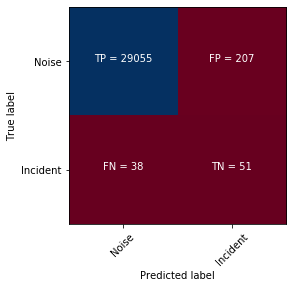

Recall=0.999 
Precision=0.993
F1=0.996
Average precision-recall score: 0.294


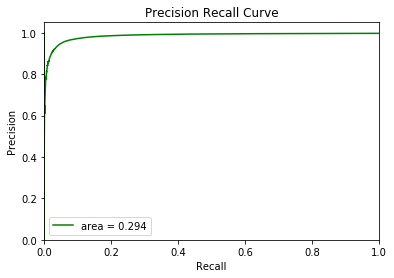

In [91]:
plot_cm(xgb, y_pred, y_test)
plot_aucprc(xgb, scores, y_test)

# Intepreting the Result

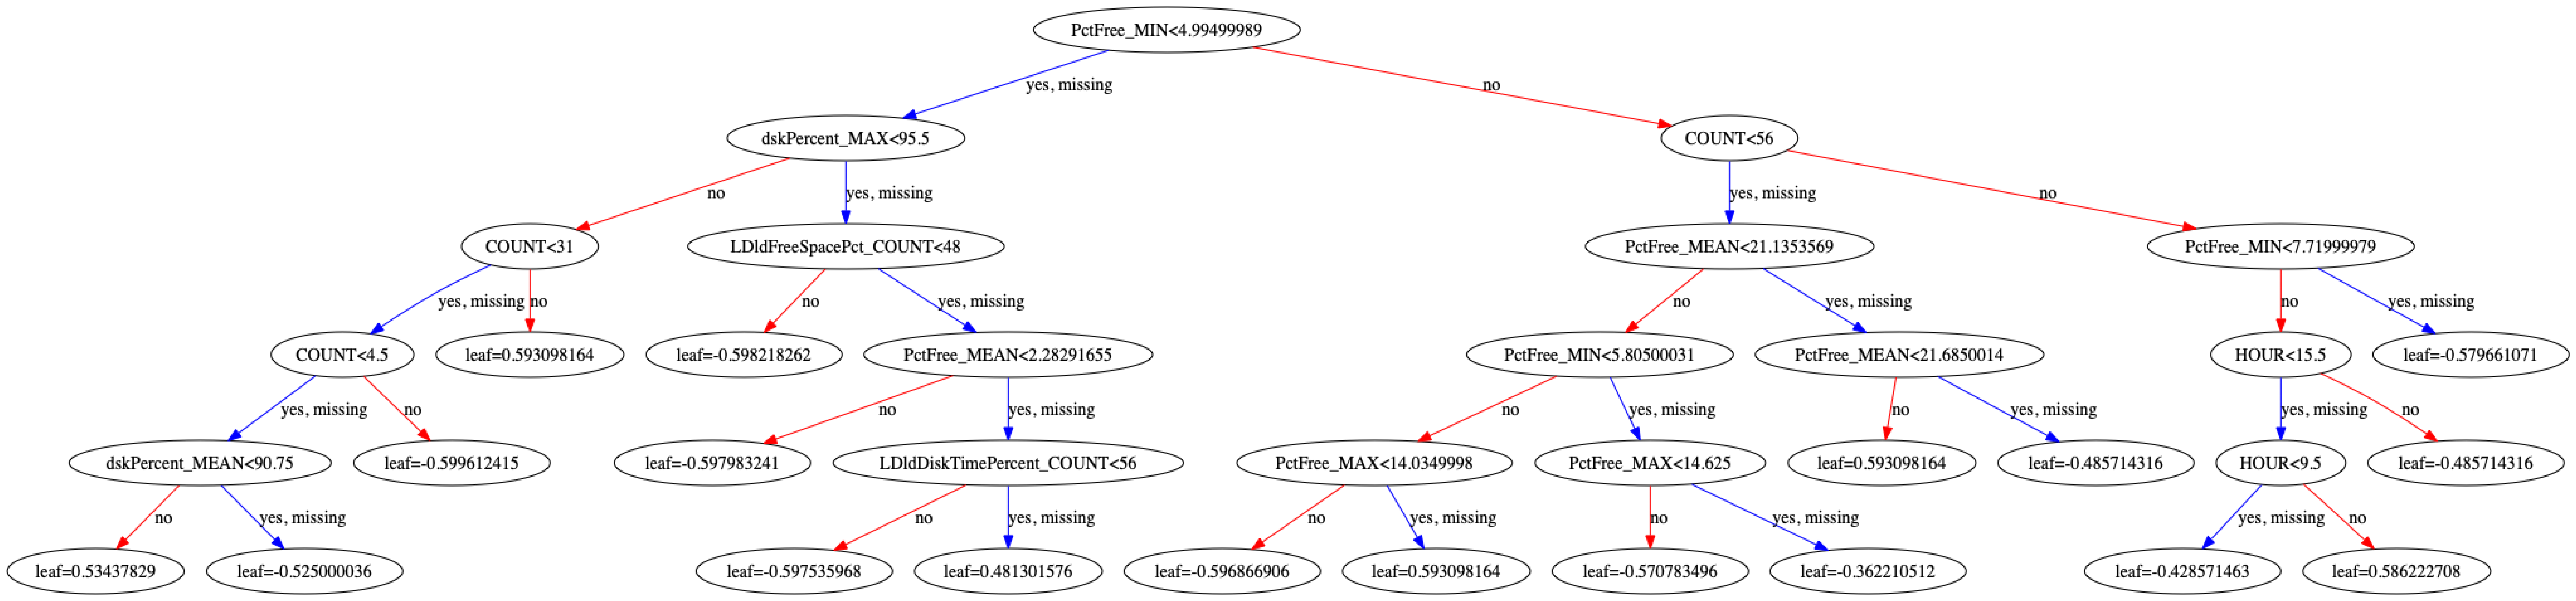

In [95]:
from xgboost import plot_tree
plot_tree(xgb)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('agg_tree.png')